# First Simple Model
I'll make a few very simple models to get a feel for the process.  I'm a bit new to time series so these are good exercises to get my feet under me. Before makign more complex models.

I'll be using COVID-19 cumulative case rates (they are daily new case rates after the first differencing).  I'll split the data at 80% through from the beginning and see how accurately my model predicts the final 20% to create a baseline for future models.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error
import sys
sys.path.append("../")
from src.model_testing import *

## Load and Prepare data
I load the latest COVID data and take the rows with national level data for the United States to develop my FSM.  I set the index as datetime because that's what the statsmodels models like, iterpolate missing data between valid entries, and drop any rows before the first or after the last valid entry that don't have data.  This leaves me with a dataframe full of valid entries for the 'ConfirmedCases' column, which will be our target.

In [2]:
df = get_covid_data()
usa_df = df[(df['Jurisdiction'] == 'NAT_TOTAL') & (df['CountryName'] == 'United States')]
usa_df = usa_df.set_index('Date', drop=True)
usa_df.index.freq = 'D'
usa_df = usa_df.interpolate(limit_direction = 'forward',limit_area = 'inside')
usa_df = usa_df.dropna(subset=['ConfirmedCases'])
usa_df.head()

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,...,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,United States,USA,NaN,NaN,NAT_TOTAL,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,3.33,3.33,3.85,3.85,0.0,0.0
2020-01-23,United States,USA,NaN,NaN,NAT_TOTAL,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,3.33,3.33,3.85,3.85,0.0,0.0
2020-01-24,United States,USA,NaN,NaN,NAT_TOTAL,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,3.33,3.33,3.85,3.85,0.0,0.0
2020-01-25,United States,USA,NaN,NaN,NAT_TOTAL,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,3.33,3.33,3.85,3.85,0.0,0.0
2020-01-26,United States,USA,NaN,NaN,NAT_TOTAL,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,3.33,3.33,3.85,3.85,0.0,0.0


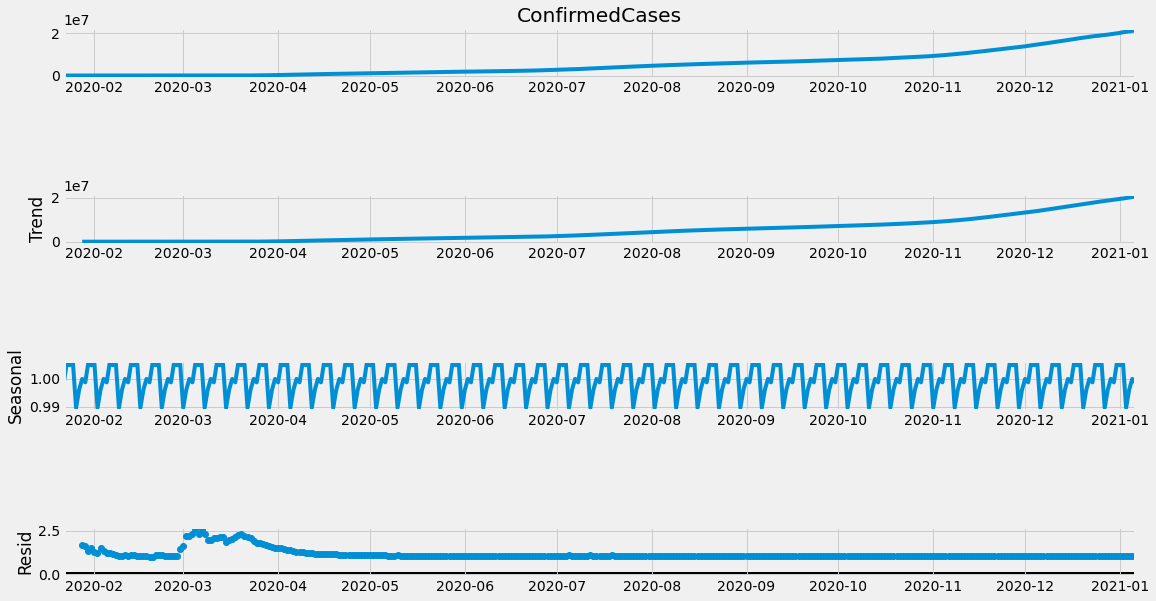

In [10]:
results = seasonal_decompose(usa_df['ConfirmedCases'], two_sided = False,
                            model = 'multiplicative')
fig = results.plot()
fig.set_size_inches((20,10))
plt.show()

We see a polynomial upward trend, weekly seasonality, and some heteroskadicity before May in the residuals.

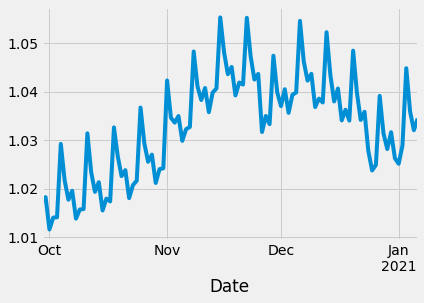

In [15]:
results.resid[-100:].plot()


The residuals still show a weekly seasonality, suggesting perhaps a second order differencing or a rolling average.

# Random Walk
for reference

Random Walk RMSE
88871.73681021328


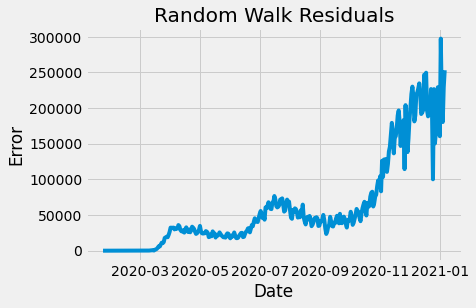

In [19]:
true = usa_df['ConfirmedCases']
pred = true.shift().fillna(0)
print('Random Walk RMSE')
RW_RMSE = np.sqrt(mean_squared_error(true,pred))
print(RW_RMSE)
plt.plot(true.index[1:],true[1:]-pred[1:], label = 'Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Random Walk Residuals')
plt.show()

The random walk has an average error of 88,871 cases.  However, this absolute error amplifies later errors when cases are higher.  It should be useful for simple comparison, though.  The residuals show rising case rates over time.  

# FSM
Our true FSM is a random walk, but let's do a simple ARIMA as well.
I suspect we will need a Sarima model, but lets start our FSM with an Arima model.

In [20]:
train = true[:-int(len(true)*.2)]
test = true[-int(len(true)*.2):]

# Training set predictions

In [30]:
test.index.date.max()

datetime.date(2021, 1, 6)

In [31]:
test.index.date.min()

datetime.date(2020, 10, 29)

FSM One-Step RMSE
5405.7007294980785
FSM Dynamic RMSE from 2020-10-29 to 2021-01-06
4336884.194634056


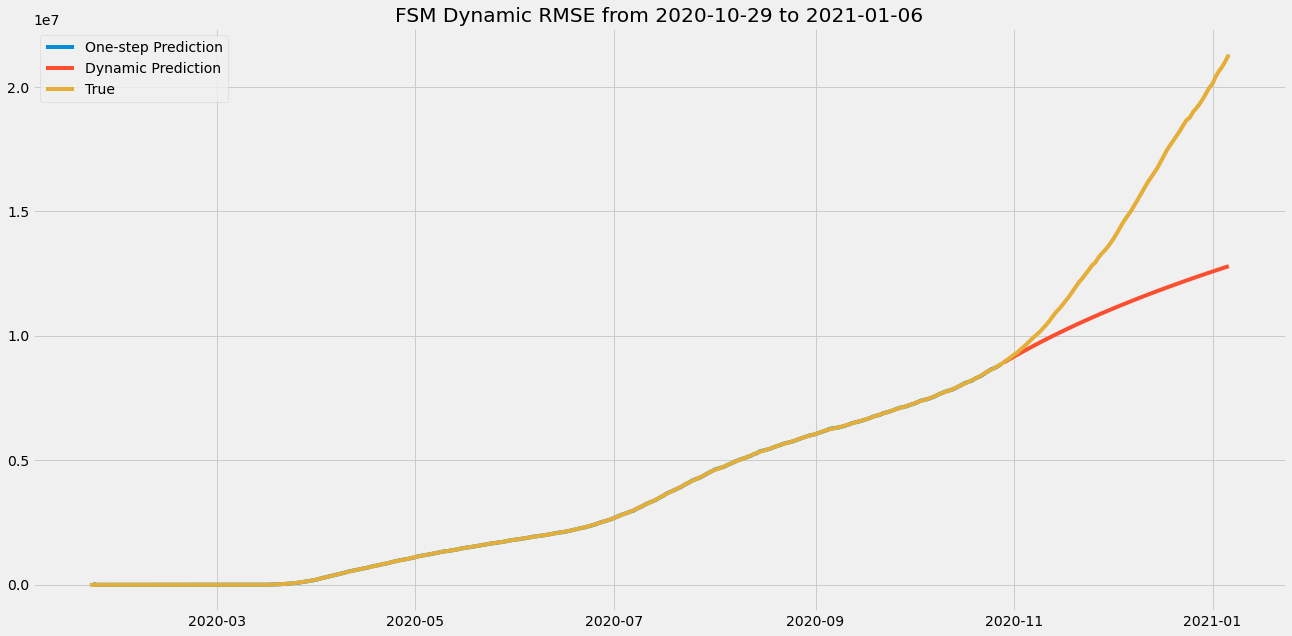

In [35]:
from statsmodels.tsa.arima_model import ARIMA
fsm = ARIMA(endog = train, order = (1,1,0), freq = 'd').fit()
y_hat = fsm.predict(typ='levels')
y_hat_dy = fsm.predict(start = test.index.min(), end= test.index.max(), 
                       typ='levels', dynamic = True)
print('FSM One-Step RMSE')
FSM_RMSE = np.sqrt(mean_squared_error(train[1:], y_hat))
print(FSM_RMSE)
print(f'FSM Dynamic RMSE from {test.index.date.min()} to {test.index.date.max()}')
print(np.sqrt(mean_squared_error(test,y_hat_dy)))

fig, ax = plt.subplots()
fig.set_size_inches((20,10))
ax.plot(y_hat, label = 'One-step Prediction')
ax.plot(y_hat_dy, label = 'Dynamic Prediction')
ax.set_title(f'FSM Dynamic RMSE from {test.index.date.min()} to {test.index.date.max()}')
ax.plot(true, label = 'True')
plt.legend()

## FSM Evaluation
Our one-step ahead prediction accuracy beats the random walk, However, our dynamic prediction from August to November does not.

We are seeing the weekly seasonality again with these results, next I will try a SARIMA model to see if I can correct for, or incorporate that seasonality.  It may be that our ARIMA model has captured something of the trend in the data, but not the seasonality.  See [sarima_model](sarima_models.ipynb) for next steps.